# Desafio 2 - NLP

- Crear sus propios vectores con Gensim basado en lo visto en clase con otro dataset.
- Probar términos de interés y explicar similitudes en el espacio de embeddings.
- Intentar plantear y probar tests de analogías. 
- Graficar los embeddings resultantes.
- Sacar conclusiones.

## Imports

In [640]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import multiprocessing
from gensim.models import Word2Vec
import os
from tensorflow.keras.preprocessing.text import text_to_word_sequence
from nltk.corpus import stopwords
import nltk
from gensim.models.callbacks import CallbackAny2Vec
from sklearn.metrics.pairwise import cosine_similarity

from sklearn.decomposition import IncrementalPCA    
from sklearn.manifold import TSNE                   
import numpy as np
import plotly.graph_objects as go
import plotly.express as px                   

## Funciones generales

In [641]:
# Durante el entrenamiento gensim por defecto no informa el "loss" en cada época
# Sobrecargamos el callback para poder tener esta información
class callback(CallbackAny2Vec):
    """
    Callback to print loss after each epoch
    """
    def __init__(self):
        self.epoch = 0

    def on_epoch_end(self, model):
        loss = model.get_latest_training_loss()
        if self.epoch == 0:
            print('Loss after epoch {}: {}'.format(self.epoch, loss))
        else:
            print('Loss after epoch {}: {}'.format(self.epoch, loss- self.loss_previous_step))
        self.epoch += 1
        self.loss_previous_step = loss

In [642]:
def reduce_dimensions(model, num_dimensions = 2 ):
     
    vectors = np.asarray(model.wv.vectors)
    labels = np.asarray(model.wv.index_to_key)  

    tsne = TSNE(n_components=num_dimensions, random_state=0)
    vectors = tsne.fit_transform(vectors)

    return vectors, labels

In [643]:
def max_words (model, vecs, labels, highlight_words, MAX_WORDS, topn=10):
    all_words = list(labels)
    selected_words = set(highlight_words)

    for word in highlight_words:
        if word in model.wv:
            try:
                similar = model.wv.most_similar(word, topn=topn)
                selected_words.update([w for w, _ in similar])
            except KeyError:
                pass  # por si alguna palabra no está en vocabulario

    for word in all_words:
        if len(selected_words) >= MAX_WORDS:
            break
        if word not in selected_words:
            selected_words.add(word)

    selected_words = list(selected_words)
    indices = [all_words.index(w) for w in selected_words if w in all_words]
    filtered_vecs = vecs[indices]
    filtered_labels = [all_words[i] for i in indices]
    return filtered_vecs, filtered_labels

In [644]:
def plot_embeddings(model, vecs, labels, MAX_WORDS=200, highlight_words=None):
    assert vecs.shape[0] == len(labels), "Vecs y labels deben tener la misma longitud"
    vecs, labels = max_words(model, vecs, labels, highlight_words, MAX_WORDS)
    # Colores: rojo si está en highlight, azul si no
    highlight_words = set(highlight_words) if highlight_words else set()
    colors = ['red' if word in highlight_words else 'blue' for word in labels]

    if vecs.shape[1] == 2:
        fig = px.scatter(
            x=vecs[:, 0],
            y=vecs[:, 1],
            text=labels,
            color=colors,
            labels={"color": "Tipo de palabra"}
        )
    elif vecs.shape[1] == 3:
        fig = px.scatter_3d(
            x=vecs[:, 0],
            y=vecs[:, 1],
            z=vecs[:, 2],
            text=labels,
            color=colors,
            labels={"color": "Tipo de palabra"}
        )
        fig.update_traces(marker_size = 2)
    else:
        raise ValueError("Los vectores deben ser de dimensión 2 o 3")

    fig.update_traces(textposition='top center')
    fig.show()

In [645]:
def embeddings_matrix_distance(model, words, extra_vector=None, extra_label="nuevo"):
    emb = np.array([model.wv.get_vector(word) for word in words])
    if extra_vector is not None:
        emb = np.vstack([emb, extra_vector])
        words = words + [extra_label]
    dist = cosine_similarity(emb, emb)
    plot_matrix_distance(words, dist)


def plot_matrix_distance(words, dist):
    fig = plt.figure(figsize=(16,9))
    ax = fig.add_subplot()
    sns.heatmap(dist, xticklabels=words, yticklabels=words, 
                annot=True, fmt=".2f", cmap="YlGnBu", ax=ax, mask=np.triu(dist))
    plt.show()

## Preprocesamiento

In [646]:
os.listdir("corpus")

['Indiana_Jones_And_The_Last_Crusade.txt',
 'Indiana_Jones_And_The_Temple_Of_Doom.txt',
 'Raiders_Of_The_Lost_Ark.txt']

In [647]:
df1 = pd.read_csv('corpus/Indiana_Jones_And_The_Last_Crusade.txt', sep='/n', header=None, engine='python')
df2 = pd.read_csv('corpus/Raiders_Of_The_Lost_Ark.txt', sep='/n', header=None, engine='python')
df3 = pd.read_csv('corpus/Indiana_Jones_And_The_Temple_Of_Doom.txt', sep='/n', header=None, engine='python')
df = pd.concat([df1, df2, df3], ignore_index=True)
display(df.head())
display("Cantidad de documentos:", df.shape[0])

,0
0,"""INDIANA JONES AND THE LAST CRUSADE"""
1,Screenplay by
2,Jeffrey Boam
3,FADE IN:
4,EXT. DESERT OF THE AMERICAN SOUTHWEST - DAY


'Cantidad de documentos:'

13504

In [648]:
nltk.download('stopwords')
stop_words = set(stopwords.words('english')) 

sentence_tokens = []
for _, row in df[:None].iterrows():
    tokens = text_to_word_sequence(row[0])  # Tokenizar con Keras
    filtered_tokens = [word for word in tokens if word not in stop_words]
    sentence_tokens.append(filtered_tokens)

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Pablo/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


## Crear los vectores (word2vec)

In [649]:
w2v_model = Word2Vec(min_count=4,    # frecuencia mínima de palabra para incluirla en el vocabulario
                     window=10,       # cant de palabras antes y desp de la predicha
                     vector_size=384, # dimensionalidad de los vectores 
                     negative=25,    # cantidad de negative samples... 0 es no se usa
                     workers=4,      # si tienen más cores pueden cambiar este valor
                     sg=1)           # modelo 0:CBOW  1:skipgram

In [650]:
w2v_model.build_vocab(sentence_tokens)
display("Cantidad de docs en el corpus:", w2v_model.corpus_count)
display("Cantidad de words distintas en el corpus:", len(w2v_model.wv.index_to_key))

'Cantidad de docs en el corpus:'

13504

'Cantidad de words distintas en el corpus:'

2214

In [651]:
w2v_model.train(sentence_tokens,
                 total_examples=w2v_model.corpus_count,
                 epochs=70,
                 compute_loss = True,
                 callbacks=[callback()]
                 )

Loss after epoch 0: 246476.765625
Loss after epoch 1: 151036.671875
Loss after epoch 2: 149662.5625
Loss after epoch 3: 147114.0
Loss after epoch 4: 146221.5
Loss after epoch 5: 143901.75
Loss after epoch 6: 132620.625
Loss after epoch 7: 122813.875
Loss after epoch 8: 121461.375
Loss after epoch 9: 119425.0
Loss after epoch 10: 116891.0
Loss after epoch 11: 115266.25
Loss after epoch 12: 113015.375
Loss after epoch 13: 109290.625
Loss after epoch 14: 107644.0
Loss after epoch 15: 101989.875
Loss after epoch 16: 94834.0
Loss after epoch 17: 93198.75
Loss after epoch 18: 91663.0
Loss after epoch 19: 90123.0
Loss after epoch 20: 88094.0
Loss after epoch 21: 87133.5
Loss after epoch 22: 85295.75
Loss after epoch 23: 83619.75
Loss after epoch 24: 81798.5
Loss after epoch 25: 80818.0
Loss after epoch 26: 79195.75
Loss after epoch 27: 78869.75
Loss after epoch 28: 77306.25
Loss after epoch 29: 77284.25
Loss after epoch 30: 75375.5
Loss after epoch 31: 74668.25
Loss after epoch 32: 75422.25
L

(2519335, 3386040)

## Pruebas

In [652]:
w2v_model.wv.most_similar(positive=["grail"], topn=10)

[('diary', 0.5156921744346619),
 ('pages', 0.4975886046886444),
 ('attempt', 0.48804399371147156),
 ('forget', 0.4830606281757355),
 ('sinister', 0.4803135395050049),
 ('page', 0.47424671053886414),
 ('knight', 0.46670621633529663),
 ('complete', 0.453093945980072),
 ('seal', 0.4484965205192566),
 ('recover', 0.4385552704334259)]

En este caso podemos ver como la palabra que mas correlación tiene con Grial es Diario, en la pelicula "Indiana Jones y la última cruzada", se menciona varias veces al diario del grial donde estaba la información de como encontrarlo. 

In [653]:
w2v_model.wv.most_similar(positive=["ark"], topn=10)

[('covenant', 0.5625528693199158),
 ('crated', 0.5050292015075684),
 ('poles', 0.4918130338191986),
 ('lid', 0.4378407299518585),
 ('rod', 0.4051535725593567),
 ('press', 0.3915233016014099),
 ('tightly', 0.3901362121105194),
 ('arrives', 0.3874222934246063),
 ('means', 0.37635865807533264),
 ('engines', 0.37488287687301636)]

En "Indiana Jones y los cazadores del arca perdida" la famosa arca se llama "el arca de la alianza" por eso la mejor correlación es con esa palabra.

In [654]:
w2v_model.wv.most_similar(positive=["sankara"], topn=10)

[('stones', 0.7111768126487732),
 ('stolen', 0.6432360410690308),
 ('sacred', 0.6325927376747131),
 ('bag', 0.605593204498291),
 ('jai', 0.5913146138191223),
 ('brothers', 0.5691648125648499),
 ('magical', 0.5669886469841003),
 ('goddess', 0.5587189197540283),
 ('gave', 0.5460003018379211),
 ('legend', 0.5295838117599487)]

En "Indiana Jones y el templo de la pedición" el objeto que Indy debe rescatar era la Piedra de Sankara, que eran unas piedras sagradas.

In [655]:
w2v_model.wv.most_similar(negative=["boulder"], topn=10)

[('interrupting', 0.06017148494720459),
 ('overlapping', 0.05369008705019951),
 ('makes', 0.052955880761146545),
 ('maybe', 0.02730393595993519),
 ('subtitled', 0.02716737985610962),
 ('matter', 0.026056069880723953),
 ('opening', 0.004290498793125153),
 ('picks', -1.647691533435136e-05),
 ('dad', -0.004436542745679617),
 ('drinks', -0.007190534844994545)]

Para la relación inversa no es que se detecten antonimos, sino palabras que no estan muy relacionadas en el espacio del embedding. No podemos sacar mucha conclusión del ejemplo.

## Visualizar agrupación de vectores

In [656]:
vecs, labels = reduce_dimensions(w2v_model)

MAX_WORDS=500
plot_embeddings(w2v_model, vecs, labels, MAX_WORDS, highlight_words=["grail","ark","sankara"])

In [657]:
vecs, labels = reduce_dimensions(w2v_model,3)

MAX_WORDS=200
plot_embeddings(w2v_model, vecs, labels, MAX_WORDS, highlight_words=["grail","ark","sankara"])

### Test de analogía

[('christ', 0.4411773085594177),
 ('complete', 0.43927597999572754),
 ('glory', 0.4332183599472046),
 ('somewhere', 0.40024369955062866),
 ('fortune', 0.38854387402534485),
 ('america', 0.3648229241371155),
 ('embrace', 0.35738053917884827),
 ('country', 0.3537747263908386)]

0.44117725

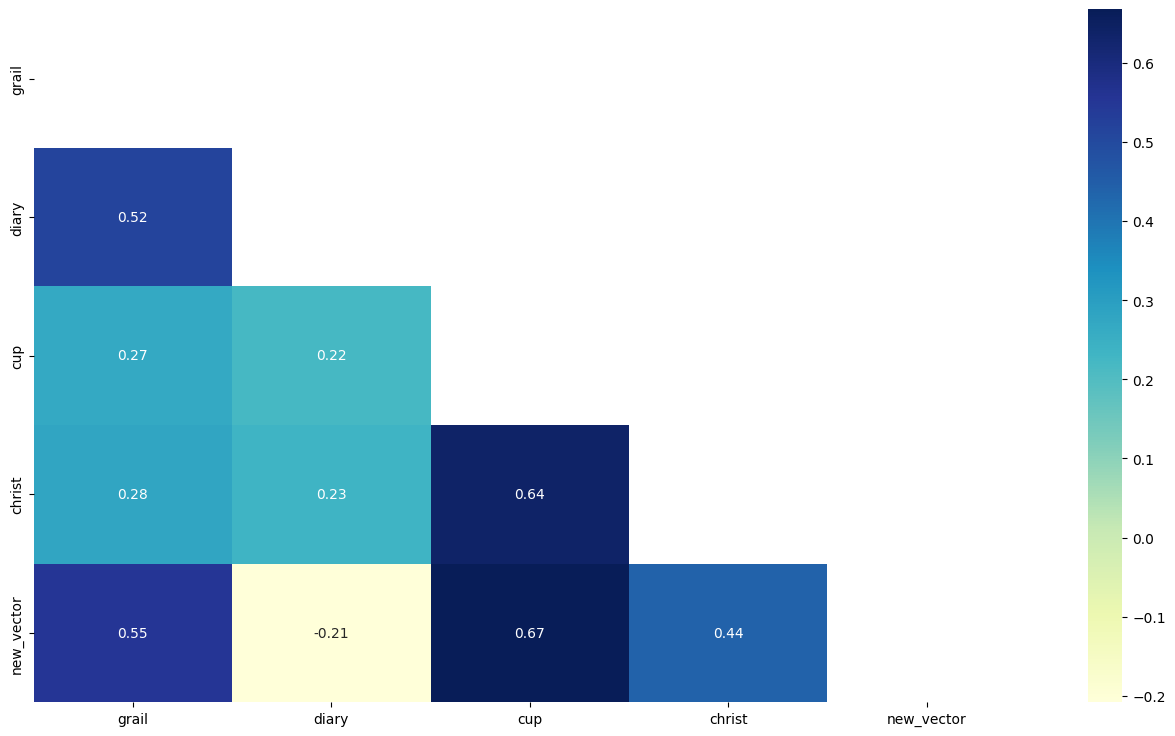

In [658]:
words = ["grail","diary","cup"]
vector1 = w2v_model.wv.get_vector(words[0])
vector2 = w2v_model.wv.get_vector(words[1])
vector3 = w2v_model.wv.get_vector(words[2])

new_vector = vector1 - vector2 + vector3

display(w2v_model.wv.most_similar(new_vector)[2:])
display(cosine_similarity([new_vector], [w2v_model.wv.get_vector("christ")])[0][0])
words.append("christ")
embeddings_matrix_distance(w2v_model, words, new_vector, "new_vector")

Se intentó hacer el test de analogía con referirise al Santo Grial como la copa y no como el diario, la correlación no es muy fuerte, pero dentro de lo mas próximo tenemos a Cristo.